In [ ]:
import json
import os
from typing import Dict
import yaml
import pandas as pd
import tensorflow as tf
import yaml
from dvclive.keras import DVCLiveCallback
from datetime import datetime
import numpy as np


from src.utils.utils_evaluate import (
    generate_metrics_semana,
    learning_curves,
    plot_predicted_series,
    plot_residual_error,
)


from src.utils.create_model import create_model
from src.utils.load_data import load_featurized_data
from src.common.logger import get_logger
from src.config.const import (
    HISTORY_PATH,
    HISTORY_PARAMS_PATH,
    TARGET_DF_PATH,
    VALUATION_PATH,
    TRAIN_MODEL_PATH,
    TRAIN_PREDICTION_PATH,
    VAL_PREDICTION_PATH,
    EVAL_ARCHIVE_PATH
)
from src.utils.data_transform import prepare_data_for_prediction, predict_load,prepare_predicted_data


import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)


In [49]:
params = yaml.safe_load(open("params.yaml"))
plt.style.use(['science','no-latex','grid',])

train_df = pd.read_csv("PFC report/rnn_direct_best_model/train_2022-11-22 01:36:11.169464_SINGLE-SHOT_['RNN', 'RNN']", index_col='din_instante')
val_df = pd.read_csv("PFC report/rnn_direct_best_model/val_2022-11-22 01:36:11.169464_SINGLE-SHOT_['RNN', 'RNN']", index_col='din_instante')
df_target = pd.read_csv('data/target/target_df.csv', index_col='Data')

with open("PFC report/rnn_direct_best_model/history_2022-11-22 01:36:11.169464_SINGLE-SHOT_['RNN', 'RNN']", "r") as history_file:
    history = json.load(history_file)

pred_list = [train_df,val_df]

In [7]:
# train_df.head()
# val_df.head()
#history

In [11]:
def learning_curves(history, skip, plot=False, model_name='rnn'):

    fig, ax = plt.subplots(figsize=(13, 18), nrows=3, ncols=1)
    metrics_list = [
        "loss",
        "val_loss",
        "mean_absolute_error",
        "val_mean_absolute_error",
        "root_mean_squared_error",
        "val_root_mean_squared_error",
    ]

    name_dict = {0: "Treino", 1: "Validação"}
    for i, metric in enumerate(metrics_list):
        # plot train and validation metrics on the same plot
        if i <= 1:
            ax1 = ax.ravel()[0]
        elif i > 1 and i <= 3:
            ax1 = ax.ravel()[1]
        else:
            ax1 = ax.ravel()[2]

        if (i % 2) == 0:
            curve_label = "Treino"
            color = 'orange'
        else:
            curve_label = "Validação"
            color = 'green'

        sns.lineplot(
            x=range(skip, len(history[metric])),
            y=history[metric][skip:],
            ax=ax1,
            label=curve_label,
            color=color
        )

    ax.ravel()[0].set_title(f"Learning Curve: EMQ (custo) - {model_name}")
    ax.ravel()[1].set_title(f"Learning Curve: EMA - {model_name}")
    ax.ravel()[2].set_title(f"Learning Curve: REMQ - {model_name}")

    for x in range(0,3):
        ax.ravel()[x].set_xlabel('epochs')

    if plot:
        plt.show()

    return fig


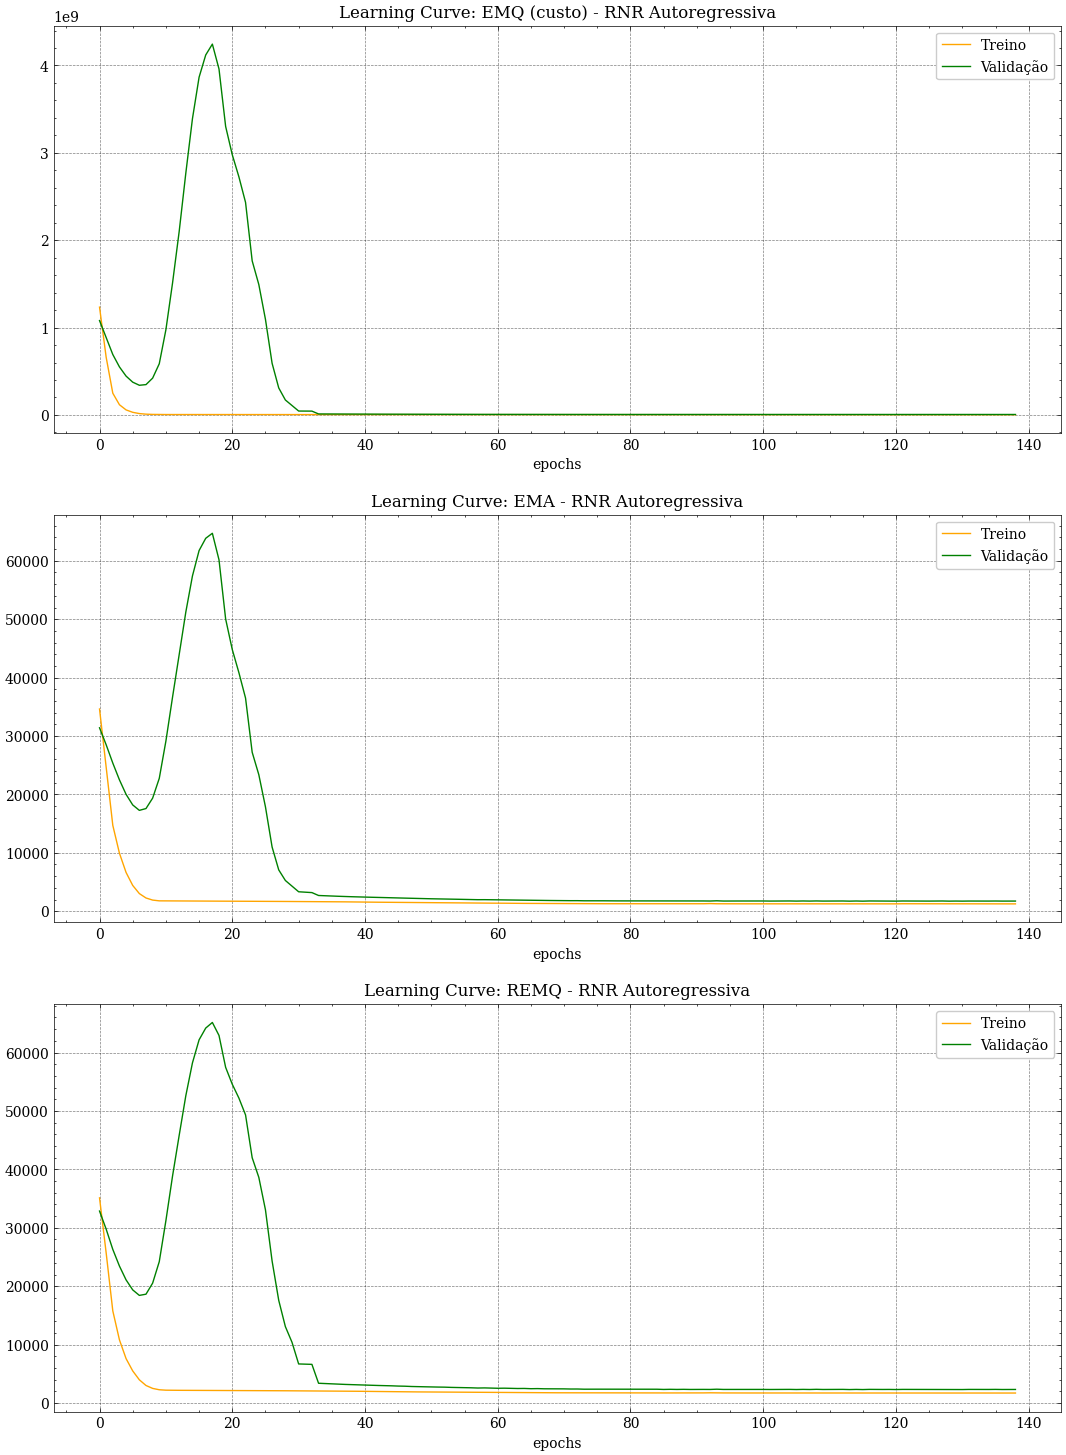

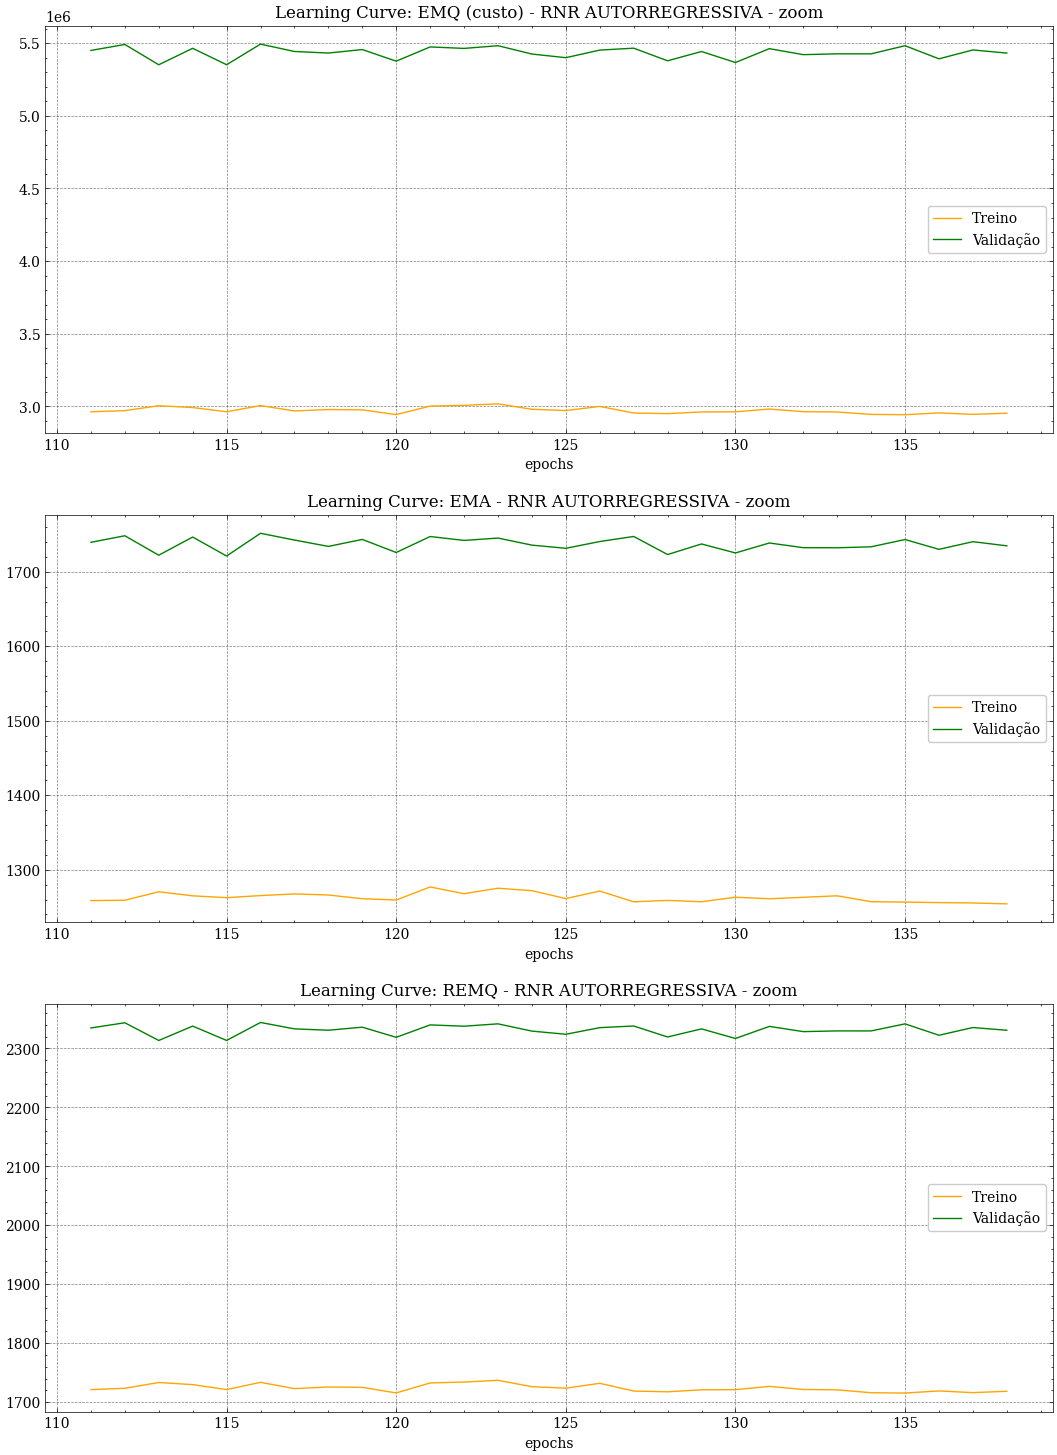

In [16]:
lc_fig = learning_curves(history=history, skip=0, plot=True, model_name="RNR Autoregressiva")
lc_fig2 = learning_curves(history=history, skip=int(len(history['loss'])*0.8), plot=True, model_name="RNR AUTORREGRESSIVA - zoom")
# lc_fig.savefig("PFC report/rnn_ar_best_model/learning_curves.png")
# lc_fig2.savefig("PFC report/rnn_ar_best_model/learning_curves.png")

In [54]:
def plot_predicted_series(pred_list, df_target, plot=False,figsize=(12,18),iterate_over=range(0,5)):

    params = yaml.safe_load(open("params.yaml"))

    window_size = params["featurize"]["WINDOW_SIZE"]
    # window size in days
    if params["featurize"]["HOW_INPUT_WINDOW_GEN"] == "daily":
        window_size = window_size / 7

    colors = ["orange", "green"]
    dataset_names = ["Treino", "Validação"]
    
    fig = plt.figure(figsize=figsize)    
    gs = fig.add_gridspec(len(iterate_over), hspace=0.30)
    ax = gs.subplots(sharex=False)

    # loop over 5 weeks
    for week_count in iterate_over:

        extra = plt.Rectangle(
            (0, 0), 0, 0, fc="none", fill=False, ec="none", linewidth=0
        )

        # plot measured data
        sns.lineplot(
            x=df_target.iloc[week_count:].index,
            y=df_target[f"Semana {week_count+1}"].iloc[: -week_count or None],
            ax=np.ravel(ax)[week_count],
            color="teal",
            label="Carga Real",
        )

        # plot predicted data
        for pred_set, color, ds_name in zip(pred_list, colors, dataset_names):
            
            # shift index so it shows date of prediction
            true_index = pred_set.index.astype("datetime64[ns]") + pd.Timedelta(
                value=7 * (window_size - 1), unit="d"
            )  # -1
            x_value = [str(index_unit).split(" ")[0] for index_unit in true_index]
            y_value = pred_set.loc[:, f"previsão semana {week_count+1}"].values

            sns.lineplot(
                x=x_value,
                y=y_value,
                ax=np.ravel(ax)[week_count],
                color=color,
                label=ds_name,
            )

        np.ravel(ax)[week_count].set_title(
            f"Carga real vs Predição em todo o período - Semana {week_count+1}"
        )

        # calculate scores
        score_list_by_dataset = []

        for pred_set in pred_list:
            pred_set_to_avaluate = pred_set.iloc[:-3]
            # generate true date index
            score_list_by_dataset.extend(
                [
                    mean_squared_error(
                        pred_set_to_avaluate.loc[:, f"previsão semana {week_count+1}"],
                        df_target[f"Semana {week_count+1}"].loc[
                            pred_set_to_avaluate["Data Previsão"].values
                        ],
                        squared=False,
                    ),
                    mean_absolute_percentage_error(
                        pred_set_to_avaluate.loc[:, f"previsão semana {week_count+1}"],
                        df_target[f"Semana {week_count+1}"].loc[
                            pred_set_to_avaluate["Data Previsão"].values
                        ],
                    )
                    * 100,
                ]
            )

        scores = (
            r"REMQ Train = {:.0f}"
            + "\n"
            + r"EMAP Train = {:.2f}%"
            + "\n\n"
            + r"REMQ val = {:.0f}"
            + "\n"
            + r"EMAP val = {:.2f}%"
        ).format(*score_list_by_dataset)

        np.ravel(ax)[week_count].legend([extra], [scores], loc="lower right")

        # add rectangle patch
        np.ravel(ax)[week_count].add_patch(extra)
        # patch coordinates
        extra_x, extra_y = extra.get_xy()
        cx = extra_x + extra.get_width() / 2.0
        cy = extra_y + extra.get_height() / 2.0
        np.ravel(ax)[week_count].annotate(
            scores,
            (cx, cy),
            color="black",
            weight="bold",
            fontsize=10,
            ha="center",
            va="center",
        )

        # np.ravel(ax)[week_count].legend(loc='upper left')

        np.ravel(ax)[week_count].xaxis.set_major_locator(mdates.MonthLocator())
        np.ravel(ax)[week_count].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=1))

        for label in np.ravel(ax)[week_count].get_xticklabels(which="major"):
            label.set(rotation=30, horizontalalignment="right")

    if plot:
        plt.show()
    return fig



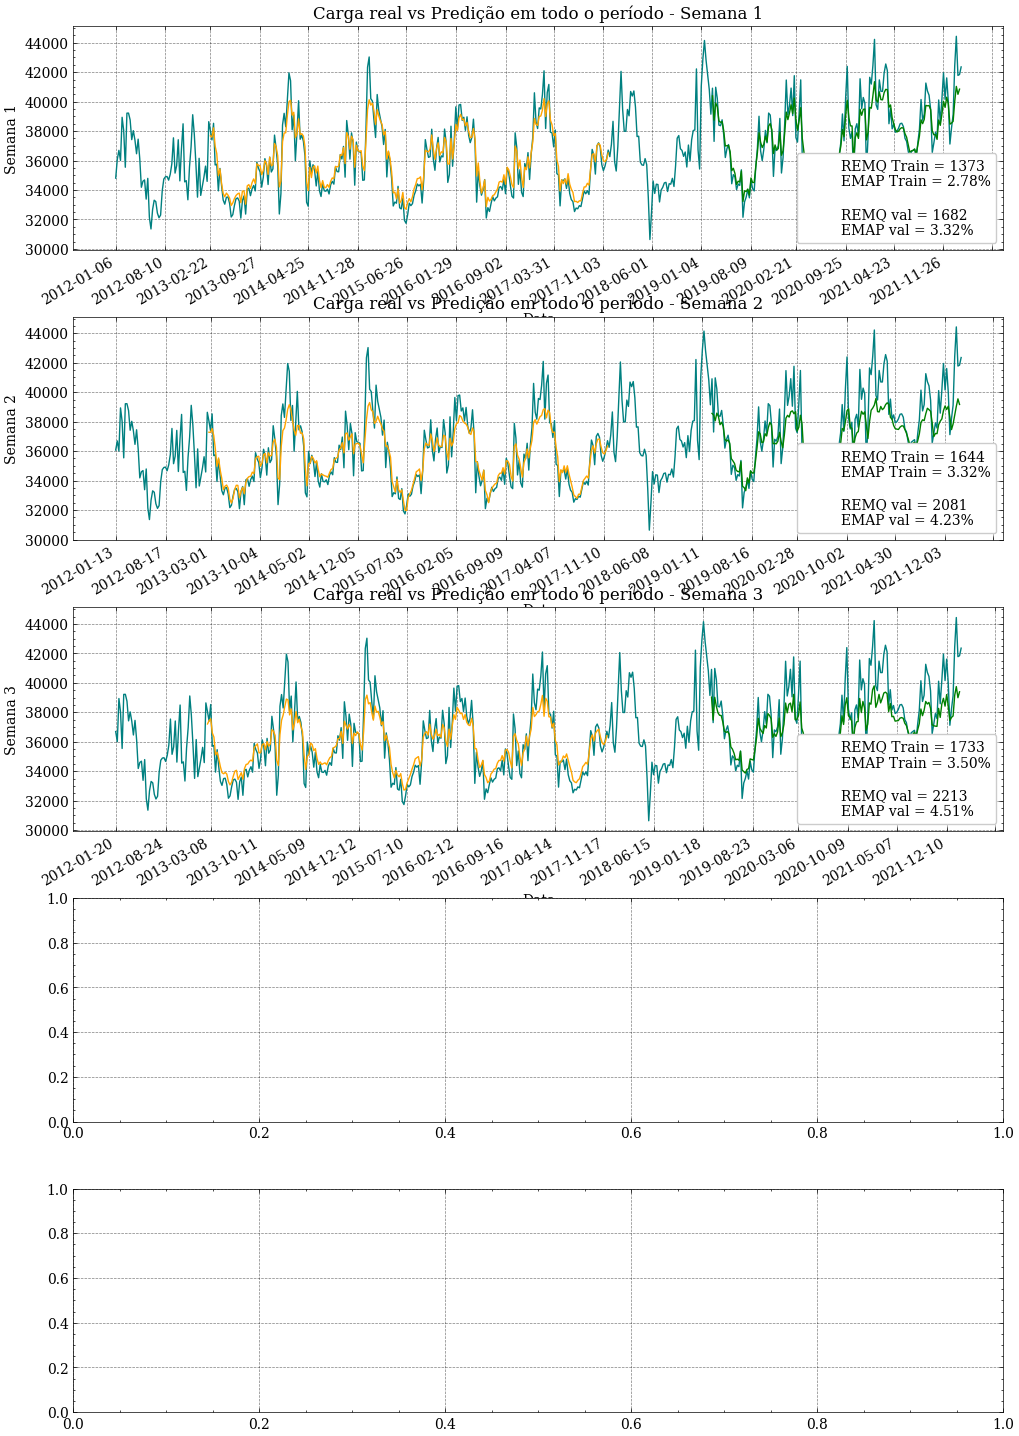

In [56]:
pred_series_fig = plot_predicted_series(
    pred_list=pred_list, df_target=df_target, plot=True, figsize=(12,18), iterate_over=range(0,3)
)
# pred_series_fig.savefig("PFC report/rnn_ar_best_model/prediction_series.png")
